<a href="https://colab.research.google.com/github/cann-emma/myfork-3001labs/blob/main/lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/msa#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [3]:
# Ensure listing is not  empty
listings[3]

<li class="cl-static-search-result" title="Vox AC15HW1X w/ Alnico Blue">
<a href="https://charlottesville.craigslist.org/msg/d/crozet-vox-ac15hw1x-alnico-blue/7781451791.html">
<div class="title">Vox AC15HW1X w/ Alnico Blue</div>
<div class="details">
<div class="price">$1,300</div>
<div class="location">
                        Crozet
                    </div>
</div>
</a>
</li>

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [4]:
data = [] # We'll save our listings in this object

items= ['violin', 'pedal', 'speaker', 'amplifier','amp','keyboard', 'banjo', 'tuba', 'case', 'electric', 'acoustic',
       'viola', 'trombone', 'trumpet', 'piano', 'french horn', 'cymbals', 'cymbal', 'reverb', 'amps', 'ukelele', 'guitar', 'guitars',
       'pacer', 'drum','cables', 'adapters', 'connecters']

for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    words = title.split()
    hits = [word for word in words if word in items] # Find brands in the title
    if len(hits) == 0:
        item = 'missing'
    else:
        item = hits[0]
    data.append({'title':title,'price':price,'link':link, 'item':item })

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [5]:
data[0:5]

[{'title': 'cables, connectors, and adapters',
  'price': '$40',
  'link': 'https://charlottesville.craigslist.org/msg/d/charlottesville-cables-connectors-and/7788424321.html',
  'item': 'adapters'},
 {'title': 'baglama saz (custom)',
  'price': '$1,800',
  'link': 'https://charlottesville.craigslist.org/msg/d/culpeper-baglama-saz-custom/7788299267.html',
  'item': 'missing'},
 {'title': 'martin d-35 (2022)',
  'price': '$2,500',
  'link': 'https://charlottesville.craigslist.org/msg/d/culpeper-martin/7788281460.html',
  'item': 'missing'},
 {'title': 'vox ac15hw1x w/ alnico blue',
  'price': '$1,300',
  'link': 'https://charlottesville.craigslist.org/msg/d/crozet-vox-ac15hw1x-alnico-blue/7781451791.html',
  'item': 'missing'},
 {'title': 'piano tuning & repair',
  'price': '$175',
  'link': 'https://charlottesville.craigslist.org/msg/d/charlottesville-piano-tuning-repair/7787801838.html',
  'item': 'piano'}]

In [6]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('instruments&accessories.csv') # Save data in case of a disaster
df.head()

(143, 4)


,title,price,link,item
0,"cables, connectors, and adapters",40,https://charlottesville.craigslist.org/msg/d/c...,adapters
1,baglama saz (custom),1800,https://charlottesville.craigslist.org/msg/d/c...,missing
2,martin d-35 (2022),2500,https://charlottesville.craigslist.org/msg/d/c...,missing
3,vox ac15hw1x w/ alnico blue,1300,https://charlottesville.craigslist.org/msg/d/c...,missing
4,piano tuning & repair,175,https://charlottesville.craigslist.org/msg/d/c...,piano


With the data in and wrangled, we can now do EDA:

In [7]:
df['item'].unique()

array(['adapters', 'missing', 'piano', 'case', 'guitar', 'amp', 'drum',
       'acoustic', 'speaker', 'electric', 'reverb', 'trumpet', 'keyboard',
       'banjo', 'guitars', 'violin', 'trombone', 'cymbal', 'pedal',
       'viola', 'tuba', 'ukelele', 'pacer'], dtype=object)

In [8]:
# Reduce redundancy
df['item']= df['item'].replace(['guitar', 'guitars', 'electric', 'acoustic'], 'guitar')

In [9]:
# Group items in data
df['category'] = df['item']

df['category'] = df['category'].replace(['guitar', 'guitars','acoustic','electric', 'banjo', 'violin', 'viola', 'ukelele'],'string')
df['category'] = df['category'].replace(['amp', 'speaker', 'case', 'reverb', 'pacer', 'pedal', 'adapters'],'accessories')
df['category'] = df['category'].replace(['trumpet', 'trombone', 'tuba'],'brass')
df['category'] = df['category'].replace(['keyboard', 'piano', 'cymbal', 'cymbals', 'drum'],'percussion')

In [10]:
df['category'].unique() # what are the distinct categories of items in data

array(['accessories', 'missing', 'percussion', 'string', 'brass'],
      dtype=object)

count     143.000000
mean      610.958042
std       999.516974
min         0.000000
25%        50.000000
50%       225.000000
75%       700.000000
max      6500.000000
Name: price, dtype: float64


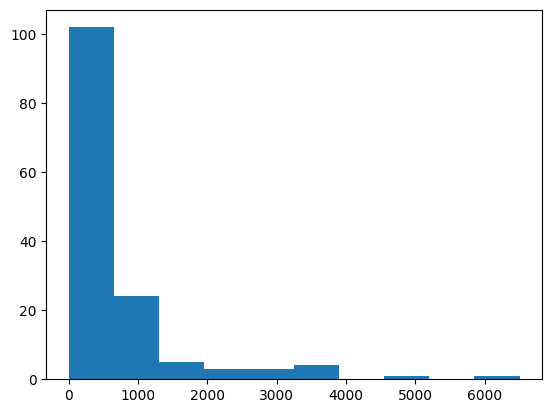

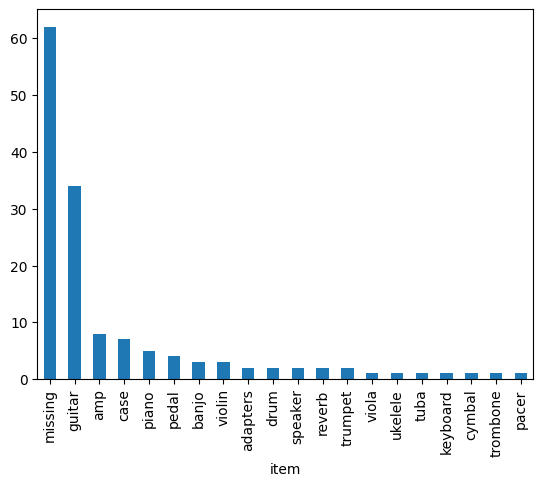

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


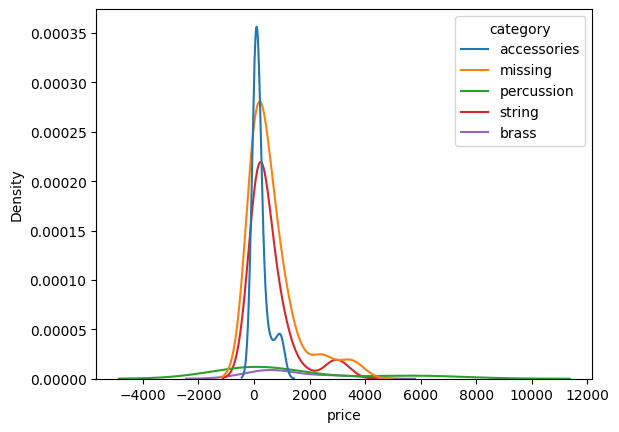

            price                                                         \
            count         mean          std    min    25%    50%     75%   
category                                                                   
accessories  26.0   221.346154   281.867336    1.0   42.5  110.0   215.0   
brass         4.0  1187.500000  1230.430142  350.0  462.5  700.0  1425.0   
missing      62.0   650.080645   896.466932    1.0   50.0  325.0   880.0   
percussion    9.0  1345.555556  2516.236580    0.0   15.0   50.0   400.0   
string       42.0   582.071429   787.050170    0.0  135.0  262.5   687.5   

                     
                max  
category             
accessories   999.0  
brass        3000.0  
missing      3800.0  
percussion   6500.0  
string       3299.0  


In [11]:
# Visualization for price and category:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
item_count= df['item'].value_counts()
item_count.plot.bar(grid=False) ## a lot of data with missing item or uncategorized item
plt.show()

sns.kdeplot(data=df, x='price',hue='category')
plt.show()

print(df[['price', 'category']].groupby('category').describe())

In [12]:
df['price'].describe() # In overall dataset, what is the summary statistics for the price.

,price
count,143.000000
mean,610.958042
std,999.516974
min,0.000000
25%,50.000000
50%,225.000000
75%,700.000000
max,6500.000000


In [ ]:
print(df[['price','item']].groupby('item').describe()) # what is the summary statistics of the price for items in dataset
print(pd.crosstab(df['item'],df['category'])) # What is the frequency of each item for each category

         price                                                              \
         count         mean          std     min      25%     50%      75%   
item                                                                         
adapters   2.0    40.000000     0.000000    40.0    40.00    40.0    40.00   
amp        8.0   175.125000   129.863046     1.0   102.50   155.0   240.00   
banjo      3.0   233.333333   166.458203   125.0   137.50   150.0   287.50   
case       6.0   172.500000   190.702648    40.0    75.00    97.5   161.25   
cymbal     1.0    20.000000          NaN    20.0    20.00    20.0    20.00   
drum       2.0  3450.000000  4313.351365   400.0  1925.00  3450.0  4975.00   
guitar    33.0   630.212121   842.794747     0.0   115.00   275.0   850.00   
keyboard   1.0    50.000000          NaN    50.0    50.00    50.0    50.00   
missing   66.0   700.030303  1097.404672     1.0    42.50   212.5   880.00   
pacer      1.0   999.000000          NaN   999.0   999.00   999.

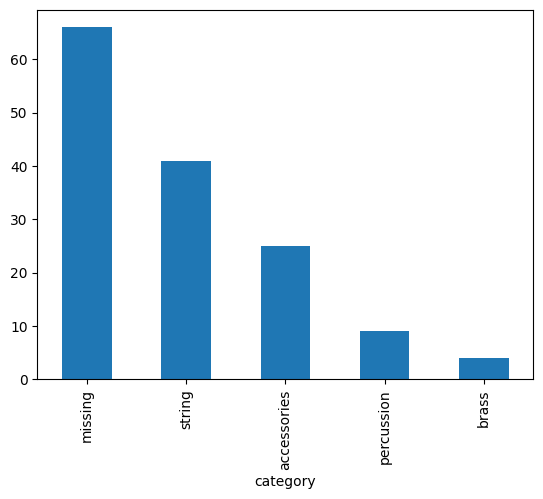

In [ ]:
category_count= df['category'].value_counts()

category_count.plot.bar(grid=False)
plt.show() # Show frequency of each category in dataset

## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

In [13]:
import time # Time delays
import random # Random numbers

links = df['link']
data = []
for link in links: # about 3 minutes
    time.sleep(random.randint(1, 3)) # Random delays
    raw = requests.get(link,headers=header) # Get page
    bsObj = soup(raw.content,'html.parser') # Parse the html
    #
    try:
        price = bsObj.find(class_='attr price').find(class_ = 'valu price').get_text()
    except:
        price = np.nan
    #
    try:
        title = bsObj.find(class_='attr auto_title_status').find(href=True).get_text()
    except:
        title='missing'
    #
    text = bsObj.find(id='postingbody').get_text()
    text = text.replace('\n','')
    text = text.replace('QR Code Link to This Post','')
    record = {'title':title,
              'price': price}
    data.append(record)

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

In [ ]:
new_df = pd.DataFrame.from_dict(data)
new_df.head()

df = pd.concat([df,new_df],axis=1) # combine data frames
df.head()

df['miles'] = df['miles'].str.replace(',','')
df['miles'] = pd.to_numeric(df['miles'],errors='coerce')

df['year_post'] = df['year_post'].str.replace(',','')
df['year_post'] = pd.to_numeric(df['year_post'],errors='coerce')
df.to_csv('craiglist_cville_cars_long.csv')